<h2>Formula 1 Grand Prix qualifying prediction</h2>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import pickle
from lightgbm import LGBMRegressor

plt.style.use('bmh')
pd.set_option('display.float_format', '{:.2f}'.format)

<h3>Data cleaning</h3>

In [2]:
rounds = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_round.csv')
round_entries = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_roundentry.csv')
sessions = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_session.csv')
session_entries = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_sessionentry.csv')
team_drivers = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_teamdriver.csv')
drivers = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_driver.csv')
teams = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_team.csv')
circuits = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_circuit.csv')
laps = pd.read_csv(r'../data/raw/jolpica-dump/formula_one_lap.csv')

race_weather = pd.read_csv(r'../data/raw/race_weather.csv')
circuit_type = pd.read_csv(r'../data/raw/circuit_type.csv')

In [3]:
df1 = pd.merge(rounds, sessions, how='left', left_on='id', right_on='round_id', suffixes=('_round', '_session'))
df2 = pd.merge(df1,round_entries,how='left',left_on='id_round', right_on='round_id', suffixes=('', '_round_entry'))
df2 = df2.rename(columns={'id': 'id_round_entry'})
df3 = pd.merge(df2,session_entries,how='left',left_on=['id_round_entry', 'id_session'],right_on=['round_entry_id', 'session_id'],suffixes=('', '_session_entry'))
df3 = df3.rename(columns={'id': 'id_session_entry'})
df4 = pd.merge(df3,team_drivers,how='left',left_on='team_driver_id',right_on='id',suffixes=('', '_team_driver'))
df4 = df4.rename(columns={'id': 'id_team_driver'})
df5 = pd.merge(df4,drivers,how='left',left_on='driver_id',right_on='id',suffixes=('', '_driver'))
df5 = df5.rename(columns={'id': 'id_driver'})
df6 = pd.merge(df5,teams,how='left',left_on='team_id',right_on='id',suffixes=('', '_team'))
df6 = df6.rename(columns={'id': 'id_team'})
df7 = pd.merge(df6,circuits,how='left',left_on='circuit_id',right_on='id',suffixes=('', '_circuit'))
df7 = df7.rename(columns={'id': 'id_circuit'})
df8 = pd.merge(df7,laps,how='left',left_on='id_session_entry',right_on='session_entry_id',suffixes=('', '_lap'))
df8 = df8.rename(columns={'id': 'id_lap'})

In [78]:
data = df8

data = data.drop(['abbreviation', 'altitude', 'average_speed', 'base_team_id', 'car_number', 'circuit_id', 'country', 'detail', 'date_round','fastest_lap_rank', 'forename', 'id_circuit', 'id_round', 'id_round_entry', 'id_session', 'id_session_entry', 'id_driver', 'id_team', 'id_team_driver', 'id_lap', 'is_deleted', 'is_eligible_for_points', 'is_entry_fastest_lap', 'latitude', 'locality', 'longitude', 'name', 'name_team', 'name_circuit', 'nationality', 'nationality_team', 'number','number_round', 'number_session', 'permanent_car_number', 'point_system_id', 'points' , 'position', 'position_lap', 'grid', 'race_number', 'role', 'round_entry_id', 'round_id', 'round_id_round_entry', 'scheduled_laps', 'season_id', 'season_id_team_driver', 'session_entry_id', 'session_id', 'status', 'surname', 'team_driver_id', 'team_id', 'time', 'wikipedia', 'wikipedia_circuit', 'wikipedia_driver', 'wikipedia_team', 'time_session_entry', 'laps_completed' ],axis=1)

In [79]:
# renames
data.rename(columns={'date_session':'date',
                     'grid':'qualification_position','country_code':'driver_nationality',
                    'country_code_team':'constructor_nationality'
                    ,'country_code_circuit':'circuit_nationality',
                     'reference_team': 'constructor',
                     'reference': 'driver',
                     'reference_circuit': 'circuit',
                     'date_of_birth':'driver_date_of_birth',
                     'time_session_entry': 'race_duration',
                     'time_lap': 'lap_duration'},inplace=True)

In [82]:
#Take only  column 'type' of value either 'Q1', 'Q2', 'Q3'
data = data[(data['type']=='Q1') | (data['type']=='Q2') | (data['type']=='Q3')]
#take only rows where 'is_cancelled_round', 'is_cancelled_session' are 'f'
data = data[(data['is_cancelled_round']=='f')]
data = data[(data['is_cancelled_session']=='f')]

# drop where is clssified is null or nan
data = data[data['lap_duration'].notna()]

# only take is_classified is true
data.drop(['is_cancelled_round', 'is_cancelled_session', 'type', 'is_classified'],axis=1,inplace=True)
data.tail(10)


,date,driver_id,driver_nationality,driver_date_of_birth,driver,constructor_nationality,constructor,circuit_nationality,circuit,lap_duration
729871,2025-09-20,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:01:42.277
729872,2025-09-20,862.00,BRA,2004-10-14,bortoleto,CHE,sauber,AZE,baku,00:02:23.974
729874,2025-09-20,845.00,GBR,1999-11-13,norris,GBR,mclaren,AZE,baku,00:01:42.239
729877,2025-09-20,831.00,NLD,1997-09-30,max_verstappen,AUT,red_bull,AZE,baku,00:01:41.117
729878,2025-09-20,851.00,JPN,2000-05-11,tsunoda,AUT,red_bull,AZE,baku,00:01:42.143
729879,2025-09-20,847.00,GBR,1998-02-15,russell,DEU,mercedes,AZE,baku,00:01:42.07
729880,2025-09-20,863.00,ITA,2006-08-25,antonelli,DEU,mercedes,AZE,baku,00:01:41.717
729887,2025-09-20,864.00,FRA,2004-09-28,hadjar,ITA,rb,AZE,baku,00:01:42.372
729888,2025-09-20,858.00,NZL,2002-02-11,lawson,ITA,rb,AZE,baku,00:01:41.707
729890,2025-09-20,830.00,ESP,1994-09-01,sainz,GBR,williams,AZE,baku,00:01:41.595


In [83]:
# check if there is any null or nan in any column
print("Null values in each column:")
print(data.isnull().sum())

Null values in each column:
date                       0
driver_id                  0
driver_nationality         0
driver_date_of_birth       0
driver                     0
constructor_nationality    0
constructor                0
circuit_nationality        0
circuit                    0
lap_duration               0
dtype: int64


In [84]:
data['date'] = pd.to_datetime(data['date'])
data['driver_date_of_birth'] = pd.to_datetime(data['driver_date_of_birth'])

#get month and day from date into new columns
data['race_month'] = data['date'].dt.month
data['race_day'] = data['date'].dt.day
data['race_year'] = data['date'].dt.year

In [85]:
data['age_at_gp_in_days'] = abs(data['driver_date_of_birth']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0]).astype(int)

first_race_dates = data.groupby('driver_id')['date'].min().reset_index()
first_race_dates.rename(columns={'date': 'first_race_date'}, inplace=True)
data = data.merge(first_race_dates, on='driver_id', how='left')
data = data.drop(['driver_id'],axis=1)

data['days_since_first_race'] = abs(data['first_race_date']-data['date'])
data['days_since_first_race'] = data['days_since_first_race'].apply(lambda x: str(x).split(' ')[0]).astype(int)

In [86]:
# Merge circuit type
data = data.merge(circuit_type, how='left', left_on='circuit', right_on='circuit', suffixes=('', '_circuit_type'))

In [87]:
#select all data from 1980
data = data[data['race_year']>=1981]
#get first nationality only


In [88]:
print(data.columns)

Index(['date', 'driver_nationality', 'driver_date_of_birth', 'driver',
       'constructor_nationality', 'constructor', 'circuit_nationality',
       'circuit', 'lap_duration', 'race_month', 'race_day', 'race_year',
       'age_at_gp_in_days', 'first_race_date', 'days_since_first_race',
       'type_circuit'],
      dtype='object')


In [51]:
#get all unique constructors
constructors = data['constructor'].unique()
print('All Constructors:')
print(constructors)

All Constructors:
['red_bull' 'aston_martin' 'ferrari' 'mercedes' 'alfa' 'alpine' 'williams'
 'alphatauri' 'haas' 'mclaren' 'sauber' 'rb']


In [52]:
data['constructor_nationality'].unique()


array(['AUT', 'GBR', 'ITA', 'DEU', 'CHE', 'FRA', 'USA'], dtype=object)

In [89]:
#data after processing nationalities
data['driver_home'] = data['driver_nationality'] == data['circuit_nationality']
data['constructor_home'] = data['constructor_nationality'] == data['circuit_nationality']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))


In [90]:
def time_to_milliseconds(time_str):
    if pd.isnull(time_str):
        return None
    try:
        # Split milliseconds
        if '.' in time_str:
            time_part, ms_part = time_str.split('.')
            ms = int(ms_part.ljust(3, '0'))  # pad to 3 digits
        else:
            time_part = time_str
            ms = 0
        dt = datetime.strptime(time_part, "%H:%M:%S")
        total_ms = (dt.hour * 3600 + dt.minute * 60 + dt.second) * 1000 + ms
        return total_ms
    except Exception:
        return None

data['lap_duration'] = data['lap_duration'].apply(time_to_milliseconds)
# rename to milliseconds
data.rename(columns={'lap_duration': 'milliseconds_qualification'}, inplace=True)

<h3>Data cleaning qualifying time</h3>

In [91]:
data_cleaned_quali_time = data.copy()

columns_to_group = [col for col in data_cleaned_quali_time.columns if col != 'milliseconds_qualification']
data_cleaned_quali_time = data_cleaned_quali_time.groupby(columns_to_group, as_index=False).agg(
    milliseconds_qualification=('milliseconds_qualification', 'min'),
)
#drop if milliseconds_qualification is 0
data_cleaned_quali_time = data_cleaned_quali_time[data_cleaned_quali_time['milliseconds_qualification'] != 0]
data_cleaned_quali_time.drop_duplicates(inplace=True)
data_cleaned_quali_time



,date,driver_nationality,driver_date_of_birth,driver,constructor_nationality,constructor,circuit_nationality,circuit,race_month,race_day,race_year,age_at_gp_in_days,first_race_date,days_since_first_race,type_circuit,driver_home,constructor_home,milliseconds_qualification
0,2006-03-11,AUS,1976-08-27,webber,GBR,williams,BHR,bahrain,3,11,2006,10788,2006-03-11,0,Race circuit,0,0,92309
1,2006-03-11,AUT,1983-02-07,klien,AUT,red_bull,BHR,bahrain,3,11,2006,8433,2006-03-11,0,Race circuit,0,0,92106
2,2006-03-11,BRA,1972-05-23,barrichello,JPN,honda,BHR,bahrain,3,11,2006,12345,2006-03-11,0,Race circuit,0,0,92322
3,2006-03-11,BRA,1981-04-25,massa,ITA,ferrari,BHR,bahrain,3,11,2006,9086,2006-03-11,0,Race circuit,0,0,91478
4,2006-03-11,CAN,1971-04-09,villeneuve,DEU,bmw_sauber,BHR,bahrain,3,11,2006,12755,2006-03-11,0,Race circuit,0,0,92456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8155,2025-09-20,JPN,2000-05-11,tsunoda,AUT,red_bull,AZE,baku,9,20,2025,9263,2021-03-27,1638,Street circuit,0,0,101788
8156,2025-09-20,MCO,1997-10-16,leclerc,ITA,ferrari,AZE,baku,9,20,2025,10201,2018-03-24,2737,Street circuit,0,0,101458
8157,2025-09-20,NLD,1997-09-30,max_verstappen,AUT,red_bull,AZE,baku,9,20,2025,10217,2015-03-14,3843,Street circuit,0,0,101117
8158,2025-09-20,NZL,2002-02-11,lawson,ITA,rb,AZE,baku,9,20,2025,8622,2023-08-26,756,Street circuit,0,0,101537


In [116]:

data_median_qualification = data_cleaned_quali_time.groupby(['circuit', 'race_year', 'date'])['milliseconds_qualification'].median().reset_index()
#rename col to median_race_duration
data_median_qualification.rename(columns={'milliseconds_qualification': 'median_qualification_duration'},inplace=True)

#merge with data_median
data_median = data_cleaned_quali_time.merge(data_median_qualification, on=['circuit', 'race_year', 'date'], how='left')

#create column deviation from median and equal to abs of race_duration - median_race_duration
data_median['deviation_from_median'] = data_median['milliseconds_qualification'] - data_median['median_qualification_duration']

data_median.drop_duplicates(inplace=True)
#round all numbers in num columns
num_cols = data_median.select_dtypes(include=[np.number]).columns
for col in num_cols:
    data_median[col] = data_median[col].round()

data_median['final_position'] = data_median.groupby(
    ['race_year', 'race_month', 'race_day', 'circuit']
)['deviation_from_median'].rank(method='min', ascending=True)

#drop where milliseconds_qualification larger than 1000000
data_median = data_cleaned_quali_time[data_cleaned_quali_time['deviation_from_median'] < 1000000]

#export to csv
#data_median.to_csv('data_cleaned_quali_time.csv', index=False)

<h3>Testing different models on cleaned qualifying data</h3>

In [117]:
# Drop irrelevant columns
columns_to_drop = [ 'driver_date_of_birth', 'date', 'first_race_date','median_qualification_duration','milliseconds_qualification', 'final_position']
data_quali_time_prepared = data_median.drop(columns=columns_to_drop)

data_quali_time_prepared.dtypes

driver_nationality          object
driver                      object
constructor_nationality     object
constructor                 object
circuit_nationality         object
circuit                     object
race_month                   int32
race_day                     int32
race_year                    int32
age_at_gp_in_days            int64
days_since_first_race        int64
type_circuit                object
driver_home                  int64
constructor_home             int64
deviation_from_median      float64
dtype: object

<h4>Split data</h4>


In [118]:
# Create a unique identifier for each race
data_quali_time_prepared['race_id'] = data_quali_time_prepared['race_year'].astype(str) + '_' + data_quali_time_prepared['race_month'].astype(str) + '_' + data_quali_time_prepared['race_day'].astype(str) + '_' + data_quali_time_prepared['circuit']

# Get unique race identifiers
race_ids = data_quali_time_prepared['race_id'].unique()

# Split race identifiers into training and testing sets
train_race_ids, test_race_ids = train_test_split(race_ids, test_size=0.2, random_state=42)

# Filter the original dataset for training and testing sets
X_train = data_quali_time_prepared[data_quali_time_prepared['race_id'].isin(train_race_ids)]
X_test = data_quali_time_prepared[data_quali_time_prepared['race_id'].isin(test_race_ids)]


test_set_with_result = X_test.copy()
test_set_with_result['final_position'] = test_set_with_result.groupby(['race_id'])['deviation_from_median'].rank(method='min', ascending=True)

# Drop the temporary race_id column
X_train = X_train.drop(columns=['race_id'])
X_test = X_test.drop(columns=['race_id'])


# Separate features and target
y_train = X_train['deviation_from_median']
X_train = X_train.drop(columns=['deviation_from_median'])



y_test = X_test['deviation_from_median']
X_test = X_test.drop(columns=['deviation_from_median'])



In [114]:
test_set_with_result

,driver_nationality,driver,constructor_nationality,constructor,circuit_nationality,circuit,race_month,race_day,race_year,age_at_gp_in_days,days_since_first_race,type_circuit,driver_home,constructor_home,deviation_from_median,race_id,final_position
0,AUS,webber,GBR,williams,BHR,bahrain,3,11,2006,10788,0,Race circuit,0,0,-147.00,2006_3_11_bahrain,9.00
1,AUT,klien,AUT,red_bull,BHR,bahrain,3,11,2006,8433,0,Race circuit,0,0,-350.00,2006_3_11_bahrain,8.00
2,BRA,barrichello,JPN,honda,BHR,bahrain,3,11,2006,12345,0,Race circuit,0,0,-134.00,2006_3_11_bahrain,10.00
3,BRA,massa,ITA,ferrari,BHR,bahrain,3,11,2006,9086,0,Race circuit,0,0,-978.00,2006_3_11_bahrain,3.00
4,CAN,villeneuve,DEU,bmw_sauber,BHR,bahrain,3,11,2006,12755,0,Race circuit,0,0,0.00,2006_3_11_bahrain,11.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,JPN,tsunoda,AUT,red_bull,HUN,hungaroring,8,2,2025,9214,1589,Race circuit,0,0,258.00,2025_8_2_hungaroring,16.00
8096,MCO,leclerc,ITA,ferrari,HUN,hungaroring,8,2,2025,10152,2688,Race circuit,0,0,-269.00,2025_8_2_hungaroring,6.00
8097,NLD,max_verstappen,AUT,red_bull,HUN,hungaroring,8,2,2025,10168,3794,Race circuit,0,0,-94.00,2025_8_2_hungaroring,8.00
8098,NZL,lawson,ITA,rb,HUN,hungaroring,8,2,2025,8573,707,Race circuit,0,0,-11.00,2025_8_2_hungaroring,10.00


<h4>Custom metric function</h4>

In [95]:
def get_weight(pos):
    if pos <= 5:
        return 3
    elif pos <= 10:
        return 2
    else:
        return 1

def get_race_weight(circuit, race_year, race_month, race_day, df):
    #return 0.5 if total entries < 10, else return 1
    #count filter df by circuit, race_year, race_month, race_day
    filtered_df = df[
    (df['circuit'] == circuit) &
    (df['race_year'] == race_year) &
    (df['race_month'] == race_month) &
    (df['race_day'] == race_day)
    ]
    
    # Count the number of entries in the filtered DataFrame
    entry_count = len(filtered_df)
    if(entry_count <5):
        return 0.2
    elif (entry_count < 10):
        return 0.5
    else:
        return 1
    
    
    
def weighted_position_error( y_true_df, X_test, ml_model):
    
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results = []
    
    #loop each row
    for index, row in joined_df.iterrows():
        # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']

        # Weight based on true rank
        

        weight = get_weight(true_pos)
        race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
        pos_error = abs(true_pos - pred_pos)
        weighted_error = race_weight* weight * pos_error

        results.append(weighted_error)
    

   
    return np.mean(results)

def get_top_5_error( y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_pred_df.merge(y_true_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    

    # Calculate true and predicted final positions
    # top 5 weights 3, next 5 weights 2, rest weights 1
    
   
    results_top5 = []
    
    #loop each row
    for index, row in joined_df.iterrows():
    # Rank true and predicted deviations (lower deviation = higher rank)
        true_pos = row['final_position']
        pred_pos = row['predicted_final_position']
        if(true_pos <= 5):
            weight = get_weight(true_pos)
            race_weight = get_race_weight(row['circuit'],row['race_year'],row['race_month'],row['race_day'],joined_df)
            pos_error = abs(true_pos - pred_pos)
            weighted_error = race_weight* weight * pos_error
        
            results_top5.append(weighted_error)
    return np.mean(results_top5)
    
def calculate_general_errors_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
 
    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae

def calculate_general_errors_top5_via_final_position(y_true_df, X_test, ml_model):
    y_pred_df = ml_model.predict(X_test)
    # Add the predicted values to the test set
    y_pred_df = pd.DataFrame(y_pred_df, columns=['predicted_deviation_from_median'])
    # Concatenate the predicted values with the test set
    y_pred_df = pd.concat([X_test.reset_index(drop=True), y_pred_df], axis=1)
    
    y_pred_df['race_id'] = y_pred_df['race_year'].astype(str) + '_' + y_pred_df['race_month'].astype(str) + '_' + y_pred_df['race_day'].astype(str) + '_' + y_pred_df['circuit']
    
    
    y_pred_df['predicted_final_position'] = y_pred_df.groupby(['race_id'])['predicted_deviation_from_median'].rank(method='min', ascending=True)
    
    y_pred_df.drop(columns=['race_id'], inplace=True)
    #join y_pred_df and y_true_df on race_year, race_month, race_day, circuit, driver, constructor
    
    joined_df = y_true_df.merge(y_pred_df, on=['race_year', 'race_month', 'race_day','circuit', 'driver', 'constructor'], how='inner')
    
    #drop rows where final_position > 5
    joined_df = joined_df[joined_df['final_position'] <= 5]

    true_pos = joined_df['final_position'].to_numpy()
    pred_pos = joined_df['predicted_final_position'].to_numpy()
    #calculate rse, rmse, r2, mae from y_test_result_position_flattened and y_pred_df
    mse = mean_squared_error(true_pos, pred_pos)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_pos, pred_pos)
    mae = mean_absolute_error(true_pos, pred_pos)
    return mse, rmse, r2, mae


In [96]:

robust_cols = [ 'age_at_gp_in_days', 'days_since_first_race']
cat_cols = ['constructor','circuit','type_circuit','driver','circuit_nationality','driver_nationality','constructor_nationality']
other_cols = ['race_year','race_month','race_day', 'driver_home', 'constructor_home']


<h3> Random forest regressor</h3>

In [119]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')
# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#      'model__max_depth': [30],
#      'model__min_samples_leaf': [2, 3, 4],
#      'model__min_samples_split': [10, 15],
#      'model__n_estimators': [600, 800]
# }

param_grid = {
     'model__max_depth': [30],
     'model__min_samples_leaf': [ 4],
     'model__min_samples_split': [15],
     'model__n_estimators': [ 800]
}
#'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)
 
# Fit
grid_search.fit(X_train, y_train)


# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_rf = grid_search.best_estimator_
y_pred = best_model_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__max_depth': 30, 'model__min_samples_leaf': 4, 'model__min_samples_split': 15, 'model__n_estimators': 800}
Best RMSE: 1507.8061429448212
Final Model Performance:
MSE: 3785353.24
RMSE: 1945.60
R2: 0.3446
MAE: 746.99


C:\Users\Linh\AppData\Local\Temp\ipykernel_24664\1203225702.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


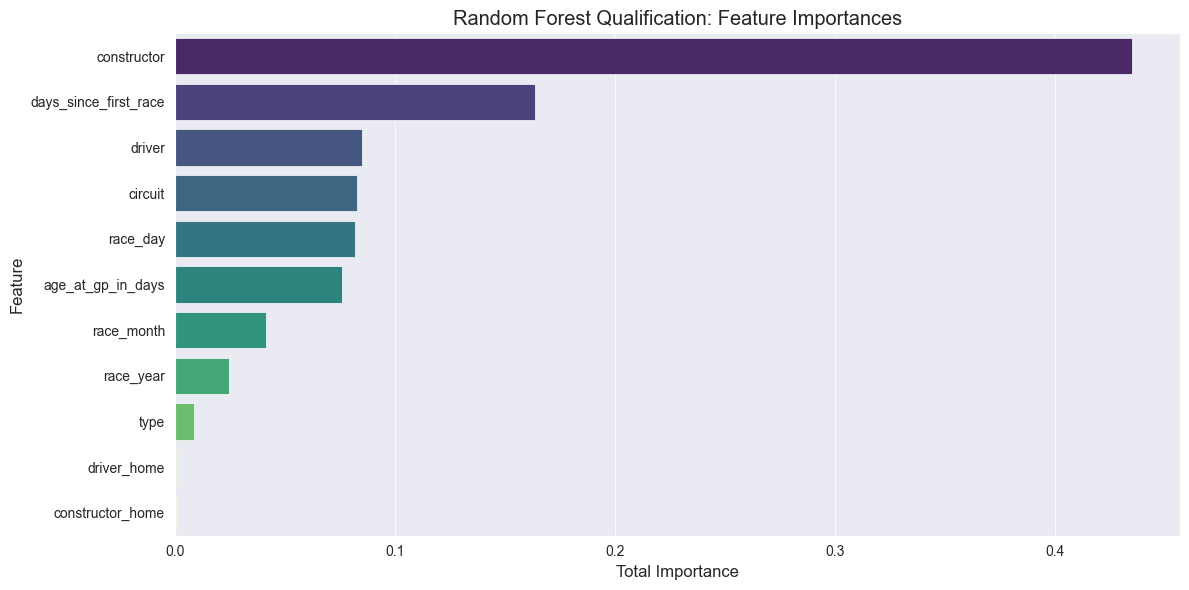

In [120]:
# Get best pipeline from grid search
best_pipeline = best_model_rf

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name

    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Random Forest Qualification: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [27]:
# save
with open('rf_qualification.pkl','wb') as f:
    pickle.dump(best_model_rf,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)


In [121]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_rf)
print(f"Weighted Position Error Random Forest: {wpe:.2f}")

wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_rf)
print(f"Top 5 Weighted Position Error Random Forest: {wpe5:.2f}")

# Calculate general errors
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Random Forest: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_rf)
print(f"General Errors Top 5 Random Forest: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Error Random Forest: 4.57
Top 5 Weighted Position Error Random Forest: 6.89
General Errors Random Forest: MSE: 15.18, RMSE: 3.90, R2: 0.6069, MAE: 2.72
General Errors Top 5 Random Forest: MSE: 13.18, RMSE: 3.63, R2: -5.5812, MAE: 2.30


<h5>Gradient boost regressor</h5>

In [122]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', GradientBoostingRegressor())
])

# GridSearchCV parameters (nested under "model__")
# param_grid = {
#     'model__loss': [ 'huber'],
#     'model__learning_rate': [0.01, 0.1],
#     'model__n_estimators': [ 300, 400],
#     'model__min_samples_split': [ 5, 10, 15],
#     'model__min_samples_leaf': [ 4, 5],
#     'model__max_depth': [ 4, 5],
# }

param_grid = {
    'model__loss': [ 'huber'],
    'model__learning_rate': [ 0.1],
    'model__n_estimators': [ 400],
    'model__min_samples_split': [ 5],
    'model__min_samples_leaf': [ 4],
    'model__max_depth': [5],
}
# Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)

# Fit
grid_search.fit(X_train, y_train)


# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_gb = grid_search.best_estimator_
y_pred = best_model_gb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'model__learning_rate': 0.1, 'model__loss': 'huber', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 400}
Best RMSE: 1516.729316381765
Final Model Performance:
MSE: 3696223.94
RMSE: 1922.56
R2: 0.3600
MAE: 702.02


C:\Users\Linh\AppData\Local\Temp\ipykernel_24664\87544156.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')


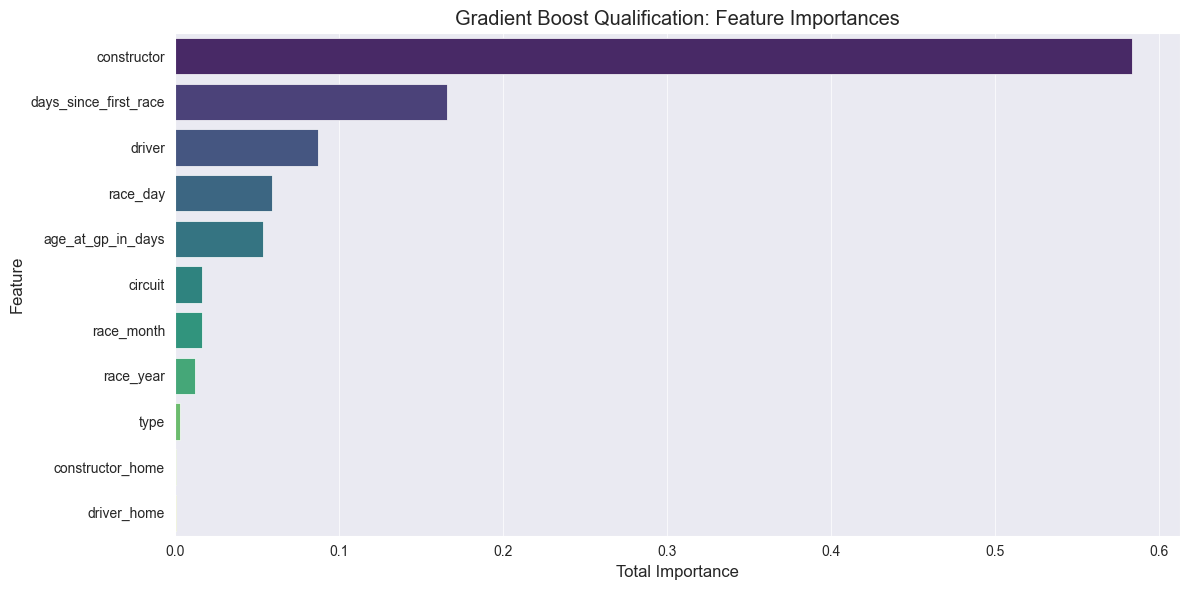

In [123]:
# Get best pipeline from grid search
best_pipeline = best_model_gb

model = best_pipeline.named_steps['model']

num_features = robust_cols

ohe = best_pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get the feature names for categorical columns
cat_features = ohe.get_feature_names_out(cat_cols)


other_features = other_cols

feature_names = np.concatenate([num_features, cat_features, other_features])


importances = model.feature_importances_

# 5. Create DataFrame for display
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# import seaborn as sns
# import matplotlib.pyplot as plt


# Step 2: Create DataFrame
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Step 3: Extract base feature name for grouping
def extract_base_feature(name):
    if name in num_features or name in other_features:
        return name

    else:
        return name.split('_')[0]  # e.g., "circuit_Monaco" -> "circuit"

feat_df['Group'] = feat_df['Feature'].apply(extract_base_feature)

# Step 4: Aggregate importance by group
grouped_importance = feat_df.groupby('Group')['Importance'].sum().sort_values(ascending=False).reset_index()

# Step 5: Plot with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_importance, x='Importance', y='Group', palette='viridis')

plt.title('Gradient Boost Qualification: Feature Importances')
plt.xlabel('Total Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [124]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_gb)
print(f"Weighted Position Gradient Boost: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_gb)
print(f"Top 5 Weighted Position Error Gradient Boost: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Gradient Boost: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_gb)
print(f"General Errors Top 5 Gradient Boost: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Gradient Boost: 4.47
Top 5 Weighted Position Error Gradient Boost: 6.66
General Errors Gradient Boost: MSE: 14.54, RMSE: 3.81, R2: 0.6235, MAE: 2.68
General Errors Top 5 Gradient Boost: MSE: 11.84, RMSE: 3.44, R2: -4.9120, MAE: 2.22


In [33]:
# save
with open('gb_qualification.pkl','wb') as f:
    pickle.dump(best_model_gb,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>Neural network</h5>

In [125]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', MLPRegressor(random_state=42, hidden_layer_sizes=(100, 100, 100, 100, 100), activation='relu', alpha=0.0001, learning_rate_init=0.001, solver='adam',max_iter=500 , verbose=1))
])

param_grid = {
    'model__hidden_layer_sizes': [ (50, 50), (100, 50)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.001, 0.01],
    'model__solver': ['adam'],
}
# Cross-validation
# k = 5
# cv = KFold(n_splits=k, shuffle=True, random_state=42)
# 
# grid_search = GridSearchCV(estimator=pipeline,
#                            param_grid=param_grid,
#                            cv=cv,
#                            scoring='neg_mean_squared_error',
#                            verbose=1,
#                            n_jobs=-1)

# grid_search.fit(X, y)



# print("Best Parameters:", grid_search.best_params_)
# best_rmse = np.sqrt(-grid_search.best_score_)
# print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

# best_model_nn = grid_search.best_estimator_
best_model_nn = pipeline.fit(X_train, y_train)
y_pred = best_model_nn.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Iteration 1, loss = 1924859.18299792
Iteration 2, loss = 1920258.20799866
Iteration 3, loss = 1919801.52104477
Iteration 4, loss = 1919060.08529431
Iteration 5, loss = 1921006.45565242
Iteration 6, loss = 1919154.89529786
Iteration 7, loss = 1923872.27456266
Iteration 8, loss = 1920732.05024711
Iteration 9, loss = 1920423.64347973
Iteration 10, loss = 1921157.05279452
Iteration 11, loss = 1919550.75753288
Iteration 12, loss = 1922928.71884971
Iteration 13, loss = 1918434.06167518
Iteration 14, loss = 1917900.23088161
Iteration 15, loss = 1916348.59280666
Iteration 16, loss = 1914926.25405605
Iteration 17, loss = 1909683.39173287
Iteration 18, loss = 1879571.02534314
Iteration 19, loss = 1763082.71422755
Iteration 20, loss = 1587666.71431303
Iteration 21, loss = 1534741.35868438
Iteration 22, loss = 1479014.92189254
Iteration 23, loss = 1455584.08817476
Iteration 24, loss = 1431865.22815999
Iteration 25, loss = 1406319.02409748
Iteration 26, loss = 1389947.86966617
Iteration 27, loss = 

In [126]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_nn)
print(f"Weighted Position Neural Network: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_nn)
print(f"Top 5 Weighted Position Error Neural Network: {wpe5:.2f}")

mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Gradient  Neural Network: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")

mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_nn)
print(f"General Errors Top 5 Neural Network: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

Weighted Position Neural Network: 5.68
Top 5 Weighted Position Error Neural Network: 9.04
General Errors Gradient  Neural Network: MSE: 21.24, RMSE: 4.61, R2: 0.4500, MAE: 3.36
General Errors Top 5 Neural Network: MSE: 19.76, RMSE: 4.45, R2: -8.8667, MAE: 3.01


In [48]:
# save
with open('nn_qualification.pkl','wb') as f:
    pickle.dump(best_model_nn,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

<h5>LightGBM</h5>

In [127]:

preprocessor = ColumnTransformer([
        ('num', RobustScaler(), robust_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ], remainder='passthrough')

# Full pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LGBMRegressor(random_state=42))
])

# param_grid = {
#     'model__n_estimators': [100, 200, 500],
#     'model__learning_rate': [0.01, 0.05, 0.1],
#     'model__max_depth': [5, 10, 20, -1],  
#     'model__num_leaves': [20, 31, 50, 100],
#     'model__min_child_samples': [5, 10, 20, 30]
# }

param_grid = {
    'model__n_estimators': [500],
    'model__learning_rate': [0.05],
    'model__max_depth': [-1],  
    'model__num_leaves': [100],
    'model__min_child_samples': [20]
}
# Cross-validation
k = 5
cv = KFold(n_splits=k, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           cv=cv,
                           scoring='neg_mean_squared_error',
                           verbose=1,
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
# Best models and performance

print("Best Parameters:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print("Best RMSE:", best_rmse)


# Evaluate on training set (optional)

best_model_lgbm = grid_search.best_estimator_
y_pred = best_model_lgbm.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Final Model Performance:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 6488, number of used features: 212
[LightGBM] [Info] Start training from score 226.435419
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': -1, 'model__min_child_samples': 20, 'model__n_estimators': 500, 'model__num_leaves': 100}
Best RMSE: 1507.5911179264422
Final Model Performance:
MSE: 4200998.24
RMSE: 2049.63
R2: 0.2727
MAE: 907.75


D:\f1-fantasy-ml-api\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [128]:
# Calculate the weighted position error
wpe = weighted_position_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Weighted Position LightGBM: {wpe:.2f}")
wpe5 = get_top_5_error( test_set_with_result, X_test, best_model_lgbm)
print(f"Top 5 Weighted Position Error LightGBM: {wpe5:.2f}")
mse, rmse, r2, mae = calculate_general_errors_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Gradient  LightGBM: MSE: {mse:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}, MAE: {mae:.2f}")
mse_top5, rmse_top5, r2_top5, mae_top5 = calculate_general_errors_top5_via_final_position(test_set_with_result, X_test, best_model_lgbm)
print(f"General Errors Top 5 LightGBM: MSE: {mse_top5:.2f}, RMSE: {rmse_top5:.2f}, R2: {r2_top5:.4f}, MAE: {mae_top5:.2f}")

D:\f1-fantasy-ml-api\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Weighted Position LightGBM: 5.28
Top 5 Weighted Position Error LightGBM: 8.49


D:\f1-fantasy-ml-api\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
D:\f1-fantasy-ml-api\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


General Errors Gradient  LightGBM: MSE: 18.57, RMSE: 4.31, R2: 0.5192, MAE: 3.11
General Errors Top 5 LightGBM: MSE: 18.08, RMSE: 4.25, R2: -8.0277, MAE: 2.83


D:\f1-fantasy-ml-api\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [47]:
# save
with open('lgbm_qualification.pkl','wb') as f:
    pickle.dump(best_model_lgbm,f)

# load
# with open('models.pkl', 'rb') as f:
#     clf2 = pickle.load(f)